## Dependencies

In [320]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

In [321]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')

def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

start = '2018-09-01 00:00:00'
end = '2019-08-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  #First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  #Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.008)

#Obtaining the maximum market price value from the market price dictionary to use as rationing cost
rationing_cost = max(market_prices_h.values())

print(len(market_prices_h))
print(rationing_cost)

8760
78.81


## Solving forward

In [322]:
## Contstraints and constants

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': rationing_cost, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

#Initializing scenarios for inflow
inflow_hydro1_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}
inflow_hydro2_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}

def inflow1_scenario(model, i, j):
    scenario_value = model.scenario.value
    if i == 'Hydro1':
        return model.inflow[i, j] == inflow_hydro1_scale[scenario_value] * inflow_hydro1[j]
    elif i == 'Hydro2':
        return model.inflow[i, j] == inflow_hydro2_scale[scenario_value] * inflow_hydro2[j]
    
# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['Buy',j] == model.L[j] - (model.r[j])

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) - (model.s[i,j]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) +(model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) -(model.s[i,j]*fm3)   

### Handling future cost

In [323]:
# Read water values and make them readable
fc = pd.read_csv('Future_cost.csv', index_col=0)
#display(fc)
#fc.plot()

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
fc.index = fc.index.map(label_parser)
fc.columns = fc.columns.astype(int)
#map so that stage in stages call on the string name of the column in the dataframe when solving later
#column_mapping = {i: f'Stage {i}' for i in range(1, 51)}   #this is needed because the column names are not integers, but strings      
# Access a specific value using a tuple as the row label
value = fc.loc[(0, 0), 1]
stage1 = fc[1].to_dict()#.reset_index(drop=True)
#print(len(fc.index))

alpha = fc[1].to_dict()
alpha_values = []

for key in fc.index:
    print("This is key:",key)
    alpha_values.append(alpha[key])

for i in range(len(fc.index)):
    print(alpha_values[i])

# ---------------------------- Water values -------------------------------------- #
wv1 = pd.read_csv('WV1.csv', index_col=0)
wv2 = pd.read_csv('WV2.csv', index_col=0)

wv1.index = wv1.index.map(label_parser)
wv2.index = wv2.index.map(label_parser)

wv1.columns = wv1.columns.astype(int)
wv2.columns = wv2.columns.astype(int)

value2 = wv1.loc[(0, 0), 1]

This is key: (0, 0)
This is key: (0, 4)
This is key: (0, 8)
This is key: (0, 12)
This is key: (0, 16)
This is key: (0, 20)
This is key: (9, 0)
This is key: (9, 4)
This is key: (9, 8)
This is key: (9, 12)
This is key: (9, 16)
This is key: (9, 20)
This is key: (18, 0)
This is key: (18, 4)
This is key: (18, 8)
This is key: (18, 12)
This is key: (18, 16)
This is key: (18, 20)
This is key: (27, 0)
This is key: (27, 4)
This is key: (27, 8)
This is key: (27, 12)
This is key: (27, 16)
This is key: (27, 20)
This is key: (36, 0)
This is key: (36, 4)
This is key: (36, 8)
This is key: (36, 12)
This is key: (36, 16)
This is key: (36, 20)
This is key: (45, 0)
This is key: (45, 4)
This is key: (45, 8)
This is key: (45, 12)
This is key: (45, 16)
This is key: (45, 20)
17889497.287243705
17820149.547605168
17589560.642093018
17585316.692861136
17485156.29076611
17516035.831904847
17579741.189177018
17611841.81999566
17623233.65135302
17397154.855793018
17304761.15621302
17323232.51173702
17265953.267093

In [324]:
def solve_first_stage(constants, topology, stage, alpha, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart']) 
    #print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    #print("This is volume", max(model.v))
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    #model.alpha_cons = pyo.Constraint(rule=create_alpha)
    model.alpha_cons = pyo.ConstraintList()   
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(45)
        Hydro2_volume.append(20)


    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i])))
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first, sense=pyo.minimize)
    return model

#Solving functions:
def OBJ_first(model):
    return model.probs*(sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha)  #should model.probs be included?

def OBJ_forward(model):
    return model.probs*(sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha)

def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [325]:
def solve_forward(constants, topology, stage, start_vol, alpha, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24+1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize={'Hydro1': start_vol[0], 'Hydro2': start_vol[1]}) 
    #print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, rule=volume_change_rule) 
    model.alpha_cons = pyo.ConstraintList()                              #Not really necessary since it's only adding one constraint that resets for every stage buy hey if it works it works
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(start_vol[0])
        Hydro2_volume.append(start_vol[1])

    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i]))) #DO THIS
    
    #alpha and lambda values from matrix created for each state and stage in the backward iteration

    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)       #model.alpha is called here and should already be defined by the constraints or variable     
    
    return model

In [326]:
## Solving forward loop for each stage after first stage
    # Solve individually for each stage and obtain the model.v values at the end of each stage
stages=range(1, 50 + 1, 1)
scenarios= ['High']#,'Avg', 'Low'] #
scenario_data = {}

Dual_values1={}
Dual_values2={}
constants['inflow_probabilities'] 
production_hydro1 = []
production_hydro2 = []
market_buy = []
market_sell = []
load = []
rationing = []
Hydro1_volume = []
Hydro2_volume = []


for s in scenarios:
    end_volume = {}
    print(' ')
    print('Solving for scenario', s)
    print(' ')
    alpha_values_scenario = []
    objective_values_scenario = []
    for stage in stages:
        if stage == 1:
            alpha = fc[stage+1].to_dict()        #Future cost in next stage, no future costs for stage 1 except one expected cost
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage+1].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage+1].to_dict() #Dual_values2
            model = solve_first_stage(constants, topology, stage, alpha, Dual_values1, Dual_values2, s)  #,
            solve(model)                         #NB! END VOLUME IN THIS MODEL DOESN'T INITIALIZE PROPERLY
            expected = model.obj()
            objective_values_scenario.append(expected)

            stage_results = ()                                                                                   # Tuple to store volume results for each stage
            for i in model.plants:
                reservoir_v = model.v[i, max(model.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                    #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model.alpha.value)
            
            #Saving values for plotting
            alpha_values_scenario.append(model.alpha.value)

            power_prod = [(plant, period, pyo.value(model.p[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in power_prod:
                if plant == 'Hydro1':
                    production_hydro1.append(val)
                elif plant == 'Hydro2':
                    production_hydro2.append(val)
            
            market = [(market, period, pyo.value(model.m['Buy', period])) for market in model.market for period in model.periods]
            for market, period, val in market:
                if market == 'Buy':
                    market_buy.append(val)

            load_values = [(period, pyo.value(model.L[period])) for period in model.periods]
            for period, val in load_values:
                load.append(val)

            rationing_values = [(period, pyo.value(model.r[period])) for period in model.periods]
            for period, val in rationing_values:
                rationing.append(val)

            volume_value = [(plant, period, pyo.value(model.v[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in volume_value:
                if plant == 'Hydro1':
                    Hydro1_volume.append(val)
                elif plant == 'Hydro2':
                    Hydro2_volume.append(val)

        else:
            alpha = fc[stage+1].to_dict()
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage+1].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage+1].to_dict() #Dual_values2

            model_forward = solve_forward(constants, topology, stage, start_vol, alpha, Dual_values1, Dual_values2, s)
            print("Start volume of stage ", stage, " is: ", model_forward.v0['Hydro1'], model_forward.v0['Hydro2'])
            solve(model_forward)

            expected = model_forward.obj() 
            objective_values_scenario.append(expected)

            power_prod = [(plant, period, pyo.value(model.p[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in power_prod:
                if plant == 'Hydro1':
                    production_hydro1.append(val)
                elif plant == 'Hydro2':
                    production_hydro2.append(val)

            market = [(market, period, pyo.value(model.m['Buy', period])) for market in model.market for period in model.periods]
            for market, period, val in market:
                if market == 'Buy':
                    market_buy.append(val)

            load_values = [(period, pyo.value(model.L[period])) for period in model.periods]
            for period, val in load_values:
                load.append(val)

            rationing_values = [(period, pyo.value(model.r[period])) for period in model.periods]
            for period, val in rationing_values:
                rationing.append(val)


            volume_value = [(plant, period, pyo.value(model.v[plant, period])) for plant in model.plants for period in model.periods]
            for plant, period, val in volume_value:
                if plant == 'Hydro1':
                    Hydro1_volume.append(val)
                elif plant == 'Hydro2':
                    Hydro2_volume.append(val)

            stage_results = ()  
            for i in model_forward.plants:
                reservoir_v = model_forward.v[i, max(model_forward.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            print("End volume of stage ", stage, " is: ", end_volume)
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model_forward.alpha.value)
            
            alpha_values_scenario.append(model_forward.alpha.value)

    scenario_data[s] = {
        "alpha_values": alpha_values_scenario,
        "objective_values": objective_values_scenario,
    }

 
Solving for scenario High
 
 
Week:  1
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1212 rows, 2857 columns and 3632 nonzeros
Model fingerprint: 0x44da2ac6
Coefficient statistics:
  Matrix range     [4e-03, 3e+04]
  Objective range  [3e-01, 3e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [1e-02, 2e+07]
Presolve removed 901 rows and 1901 columns
Presolve time: 0.01s
Presolved: 311 rows, 956 columns, 1265 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9109304e+06   6.077805e+00   0.000000e+00      0s
     310    6.0116175e+06   0.000000e+00   0.000000e+00      0s

Solved in 310 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.011617534e+06
This is the alpha value: 17900099.1163646
 
Week:  

## Power production

[79.21919667934587, 77.90591385935481, 77.64852486511728, 77.29347280592198, 77.25582620484772, 77.5857239937169, 77.9442536636889, 78.68416173435341, 81.68308935724271, 83.01428766304498, 84.25877034059373, 84.50837003870916, 84.1569966447233, 83.52539258192499, 83.12837019305267, 82.60311479353332, 82.85574850781258, 83.54907300478206, 83.64119785801313, 83.6758428965088, 83.6188580077798, 83.32668461223079, 81.99069317203542, 80.09874987408612, 78.49106761923538, 77.31597748511011, 77.02297417138361, 76.52657745798122, 76.49426938858646, 76.81478881615259, 76.92475569681356, 77.13576009892107, 79.32132161382495, 80.22461558600013, 81.65797181721517, 82.2865107299701, 82.2134967029708, 81.99463481135487, 82.16559413599836, 82.4181076915699, 82.66710223680289, 82.99053481869369, 83.12366436729613, 83.61330051069218, 84.65606943638817, 84.82374866846042, 83.5316728244192, 80.87924916129991, 77.67502687796899, 76.68766677654209, 76.69476940596556, 76.62065507071999, 77.05452564504422, 7

c:\Users\benny\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


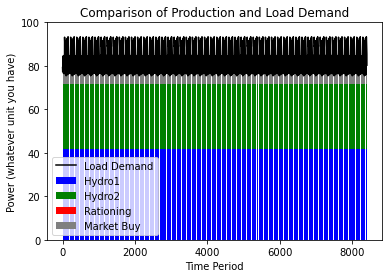

In [327]:
# Calculate the bottom values for Hydro2 and market_buy to stack them on Hydro1
#bottom_hydro2 = np.add(production_hydro1, production_hydro2)

print((load))
print((production_hydro1))
print(production_hydro2)
print((market_buy))
print(rationing)

rationing_array = np.array(rationing)

# Create the stacked bar plot
fig, ax = plt.subplots()

# Plot Hydro1 production
ax.bar(np.arange(len(production_hydro1)), production_hydro1, label='Hydro1', color = 'blue')

# Plot Hydro2 production stacked on Hydro1
ax.bar(np.arange(len(production_hydro2)), production_hydro2, bottom=production_hydro1, label='Hydro2', color='green')

ax.bar(np.arange(len(rationing)), rationing, bottom=np.add(production_hydro1,production_hydro2), label='Rationing', color='red')

# Plot market buy stacked on Hydro2
ax.bar(np.arange(len(market_buy)), market_buy, bottom=np.add(production_hydro1,production_hydro2,rationing_array), label='Market Buy', color='grey')

# Plot load demand as a curve above the bars
ax.plot(np.arange(len(load)), load, label='Load Demand', color='black')

# Customize the plot
ax.set_xlabel('Time Period')
ax.set_ylabel('Power (whatever unit you have)')
ax.set_title('Comparison of Production and Load Demand')
ax.legend()
ax.set_ylim(0, 100)
# Show the plot
plt.show()

## Volume (Hourly)

In [ ]:
rationing_array = np.array(rationing)

# Create the stacked bar plot
fig, ax = plt.subplots()

# Plot Hydro1 volume
ax.plot(np.arange(len(Hydro1_volume)), Hydro1_volume, label='Ormsetvatn', color = 'blue')

# Plot Hydro2 volume
ax.plot(np.arange(len(Hydro2_volume)), Hydro2_volume, label='Buavatn', color='black')

# Customize the plot
ax.set_xlabel('Time Period')
ax.set_ylabel('Power (whatever unit you have)')
ax.set_title('Comparison of Production and Load Demand')
ax.legend()
ax.set_ylim(0, 100)
# Show the plot
plt.show()

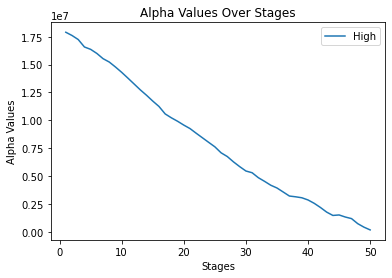

In [328]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    alpha_values_scenario = scenario_data[s]["alpha_values"]
    x_values = range(1, len(alpha_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, alpha_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Alpha Values')
ax.set_title('Alpha Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()


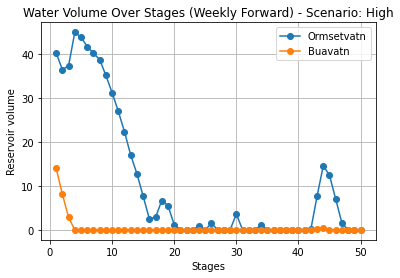

In [329]:
# Extract the keys (stages) and values from the dictionaries
stages = list(end_volume.keys())
values1 = [item[0] for item in end_volume.values()]
values2 = [item[1] for item in end_volume.values()]

plt.plot(stages, values1, label='Ormsetvatn', marker='o', linestyle='-')
plt.plot(stages, values2, label='Buavatn', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Reservoir volume')
plt.title('Water Volume Over Stages (Weekly Forward) - Scenario: High')

# Add a legend to differentiate between Dual_values1 and Dual_values2
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

#Plot hourly!!!

In [330]:
print(scenario_data[s]["objective_values"])

[6011617.533526842, 5910047.989790216, 5796590.567668537, 5579079.614799497, 5575788.294754595, 5466809.702034917, 5299845.513652526, 5217538.0449608285, 5080642.92092916, 4930545.676393915, 4763381.75742702, 4609511.030270007, 4446663.879082425, 4274267.950034783, 4123546.51632185, 3978059.0805731085, 3712042.579853354, 3601330.2370066517, 3510408.3417684175, 3396178.7539399574, 3381603.1362536037, 3251917.3909192886, 3103203.3505537324, 2916082.0472228457, 2739858.8448659554, 2532829.862779425, 2471474.869513697, 2328447.914614845, 2154901.1795915244, 1990990.6749466846, 1898830.6685591007, 1831367.2503497743, 1705189.2895124038, 1504543.753158975, 1437208.9773299024, 1361663.6653265185, 1219139.3324253242, 1201511.3166580717, 1158195.8373431447, 1063502.7162554697, 931414.920517428, 833857.6052001361, 688298.7576524338, 602793.7262381564, 589654.5255140263, 513314.6682522894, 465697.44609341776, 364812.2796570038, 279038.0303438565, 132537.83530567313]


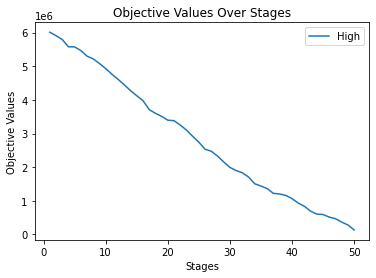

In [331]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    objective_values_scenario = scenario_data[s]["objective_values"]
    x_values = range(1, len(objective_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, objective_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Objective Values')
ax.set_title('Objective Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()

In [332]:
#!git reset --hard HEAD~5

In [333]:
#!git log